# **Time Series Forecasting**

Analisis deret waktu (time series) merupakan pendekatan yang digunakan untuk memahami pola data yang tersusun berdasarkan urutan waktu. Dengan mempelajari pola historis, kita dapat mengidentifikasi tren, musiman, maupun fluktuasi acak yang ada di dalam data.  

Data yang digunakan dalam analisis ini berasal dari satelit Sentinel‑5P, yaitu misi penginderaan jauh milik European Space Agency (ESA) yang dirancang khusus untuk memantau kualitas udara global. Akses data dilakukan melalui platform openEO, sebuah antarmuka pemrosesan data penginderaan jauh berbasis cloud yang memungkinkan pengguna mengambil dan mengolah data satelit tanpa harus mengunduh seluruh arsip mentah.
Wilayah kajian difokuskan pada kota Surabaya di Jawa Timur, Indonesia. Area ini didefinisikan menggunakan koordinat geografis dalam bentuk kotak pembatas (bounding box) yang mencakup keseluruhan wilayah kota. Pemilihan Surabaya didasarkan pada karakteristiknya sebagai kota metropolitan dengan aktivitas transportasi dan industri yang tinggi, sehingga relevan untuk dianalisis dari sisi kualitas udara.
Variabel utama yang diambil dari Sentinel‑5P adalah konsentrasi Nitrogen Dioksida (NO₂). Gas ini dipilih karena merupakan salah satu polutan udara utama yang berhubungan erat dengan aktivitas manusia, terutama pembakaran bahan bakar fosil. Data NO₂ dari Sentinel‑5P tersedia dalam resolusi temporal harian, sehingga memungkinkan pembentukan deret waktu yang cukup detail untuk dianalisis lebih lanjut menggunakan metode forecasting.

## **1. Install Dependency yang diperlukan**

In [ ]:
pip install openeo netCDF4 matplotlib scikit-learn

- opene0: untuk akses data satelit
- netCDF4: membaca dan menulis file NetCDF.
- matplotlib: untuk membuat grafik/visualisasi data.
- sk-learn: pustaka pembelajaran mesin (ML)

File NetCDF adalah format standar untuk data ilmiah multidimensi, misalnya data satelit, iklim, atau atmosfer.


### **1.1 Import dependency**

In [78]:
import openeo
import datetime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

- import datetime
→ Modul bawaan Python untuk bekerja dengan tanggal dan waktu.
- import xarray as xr
→ Library untuk membaca dan mengolah data ilmiah multidimensi.
- import pandas as pd
→ Library untuk analisis data berbasis tabel (DataFrame).
- from sklearn.model_selection import train_test_split
→ fungsi dari scikit‑learn untuk membagi dataset jadi data latih (train) dan data uji (test).
- from sklearn.preprocessing import MinMaxScaler
→ fungsi dari scikit‑learn untuk normalisasi data menggunakan min-max scaler
- from sklearn.neighbors import KNeighborsRegressor
→ untuk membuat model KNN Regression).
- from sklearn.metrics import mean_absolute_error, mean_squared_error
→ untuk menghitung akurasi model dengan metrik error (MAE, RMSE).
- import numpy as np
→ dipakai untuk operasi numerik



## **2. Pengambilan Data**

### **2.1 Koneksi ke openeo**

In [3]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

coll = connection.describe_collection("SENTINEL_5P_L2")

Authenticated using refresh token.


- connection = openeo.connect("https://openeo.dataspace.copernicus.eu")
→ Membuat koneksi dari Python ke backend openEO Copernicus Data Space.
- connection.authenticate_oidc()
→ Melakukan login (autentikasi) dengan akun Copernicus Data Space.
- coll = connection.describe_collection("SENTINEL_5P_L2")
→ Meminta deskripsi metadata dari koleksi data Sentinel‑5P Level‑2. Hasilnya berisi info tentang variabel apa saja yang tersedia (misalnya NO₂, CO, O₃), resolusi spasial, temporal, sistem koordinat, dsb.


### **2.2 Pengambilan data berdasarkan wilayah**

In [7]:
aoi = {
    "west": 112.59173985465924,
    "south": -7.352740006148423,
    "east": 112.85006335219384,
    "north": -7.192706605107787
}

Mendefinisikan Area of Interest (AOI) berupa koordinat batas wilayah Surabaya, yang diambil dari geojson.io.

### **2.3 Pengaambilan data berdasarkan rentang waktu**

In [8]:
today = datetime.date.today()
start_date = today - datetime.timedelta(days=3*365)
end_date = today - datetime.timedelta(days=14)

start_str, end_str = str(start_date), str(end_date)

Mengambil data 3 tahun kebelakang.


### **2.4 Muat data**

In [ ]:
import os

outfile = "no2_surabaya_3tahun.nc"

if not os.path.exists(outfile):
    job = cube.execute_batch(
        title="NO2 Surabaya 3 Tahun",
        outputfile=outfile,
        out_format="NetCDF"
    )
else:
    print("File sudah ada, skip.")

Muat data NO2 berdasarkan rata-rata harian dan simpan file format nc(NetCDF)

### **2.5 Simpan data ke CSV**

In [52]:
ds = xr.open_dataset(outfile, engine="netcdf4")
df = ds.to_dataframe().reset_index()

df.to_csv("no2_surabaya_3tahun.csv", index=False)

## **3. Memahami data**

### **3.1 Informasi data (kolom, dimensi, struktur, statistik)**

In [53]:
print(df.head())

           t           x         y  crs  NO2
0 2022-10-21  112.619022 -7.210068  b''  NaN
1 2022-10-21  112.619022 -7.244790  b''  NaN
2 2022-10-21  112.619022 -7.279512  b''  NaN
3 2022-10-21  112.619022 -7.314234  b''  NaN
4 2022-10-21  112.619022 -7.348957  b''  NaN


In [54]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26875 entries, 0 to 26874
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t       26875 non-null  datetime64[ns]
 1   x       26875 non-null  float64       
 2   y       26875 non-null  float64       
 3   crs     26875 non-null  object        
 4   NO2     14373 non-null  float32       
dtypes: datetime64[ns](1), float32(1), float64(2), object(1)
memory usage: 945.0+ KB
None


In [41]:
print(df.columns)

Index(['t', 'x', 'y', 'crs', 'NO2'], dtype='object')


In [42]:
print(ds.dims)
print(ds.coords)

FrozenMappingWarningOnValuesAccess({'t': 1075, 'x': 5, 'y': 5})
Coordinates:
  * t        (t) datetime64[ns] 9kB 2022-10-21 2022-10-22 ... 2025-10-05
  * x        (x) float64 40B 112.6 112.7 112.7 112.8 112.8
  * y        (y) float64 40B -7.21 -7.245 -7.28 -7.314 -7.349


In [43]:
print(df['NO2'].describe())

count    14373.000000
mean         0.000045
std          0.000034
min         -0.000031
25%          0.000025
50%          0.000037
75%          0.000055
max          0.000448
Name: NO2, dtype: float64


### **3.2 Visualisai data**

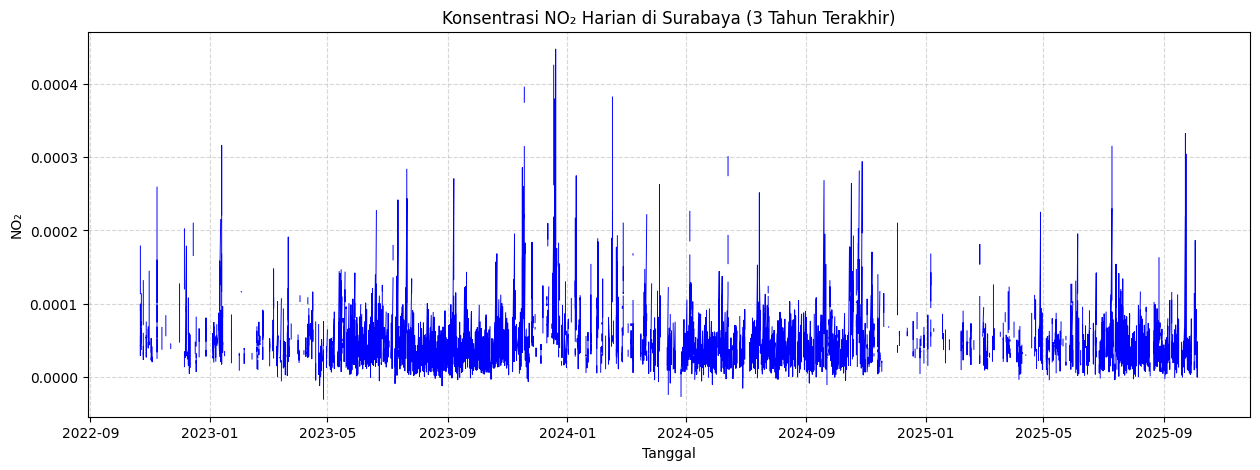

In [62]:
df = pd.read_csv("no2_surabaya_3tahun.csv")

df['t'] = pd.to_datetime(df['t'])

plt.figure(figsize=(15,5))
plt.plot(df['t'], df['NO2'], color='blue', linewidth=0.7)
plt.title("Konsentrasi NO₂ Harian di Surabaya (3 Tahun Terakhir)")
plt.xlabel("Tanggal")
plt.ylabel("NO₂")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### **3.3 Cek Missing Value**

In [63]:
print(df.isna().sum())
df['NO2'].isna().mean()

t          0
x          0
y          0
crs        0
NO2    12502
dtype: int64


np.float64(0.4651906976744186)

Terdapat Missing value pada kolom NO2 sebanyak 12.502, 46% dari data keseluruhan.

## **4. Preprocessing data**

### **4.1 Penanganan Missing values**

Menangani Missing value menggunakan interpolasi linear berdasarkan waktu.

In [64]:
# pastikan kolom t sudah datetime dan jadi index
df['t'] = pd.to_datetime(df['t'])
df = df.set_index('t')

# interpolasi linear berbasis waktu
df['NO2'] = df['NO2'].interpolate(method='time')

# reset index
df = df.reset_index()

print(df['NO2'].isna().sum())

25


 setelah interpolasi masih tersisa 25 NaN, biasanya ada dua penyebab utama:
- NaN di ujung awal/akhir time series, interpolasi tidak bisa mengisi karena tidak ada data sebelum/ sesudahnya.
- Ada gap terlalu panjang


In [65]:
# isi sisa NaN di awal/akhir
df['NO2'] = df['NO2'].bfill().ffill()

print(df['NO2'].isna().sum())

0


## **5. Modelling**
### **5.1 Buat data supervised (Lag feature)**


In [66]:
df['NO2_lag1'] = df['NO2'].shift(1)
df['NO2_lag7'] = df['NO2'].shift(7)

print(df.head())

# hapus baris yang ada NaN 
df = df.dropna().reset_index(drop=True)

print(df.head())


           t           x         y  crs       NO2  NO2_lag1  NO2_lag7
0 2022-10-21  112.619022 -7.210068  b''  0.000212       NaN       NaN
1 2022-10-21  112.619022 -7.244790  b''  0.000212  0.000212       NaN
2 2022-10-21  112.619022 -7.279512  b''  0.000212  0.000212       NaN
3 2022-10-21  112.619022 -7.314234  b''  0.000212  0.000212       NaN
4 2022-10-21  112.619022 -7.348957  b''  0.000212  0.000212       NaN
           t           x         y  crs       NO2  NO2_lag1  NO2_lag7
0 2022-10-21  112.673585 -7.279512  b''  0.000212  0.000212  0.000212
1 2022-10-21  112.673585 -7.314234  b''  0.000212  0.000212  0.000212
2 2022-10-21  112.673585 -7.348957  b''  0.000212  0.000212  0.000212
3 2022-10-21  112.728149 -7.210068  b''  0.000212  0.000212  0.000212
4 2022-10-21  112.728149 -7.244790  b''  0.000212  0.000212  0.000212


### **5.2 Normalisasi data**

menggunakan Min-Max scaler

In [75]:
features = ['NO2_lag1', 'NO2_lag7']
X = df[features].dropna()
y = df['NO2'].dropna()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### **5.3 Split data**
pisahkan train/test. 80% untuk training, 20% untuk testing.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=False, test_size=0.2)

### **5.4 Training model**

Menggunakan model KNN Regression

In [79]:
# buat model KNN dengan k=5
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# prediksi di data test
y_pred = model.predict(X_test)

### **5.5 Evaluasi**

In [80]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1.166841950539323e-05
RMSE: 2.0644633525746885e-05


hasil error dengan rata‑rata model sangat kecil sekali.
- MAE = rata‑rata kesalahan biasa.
- RMSE = rata‑rata kesalahan yang lebih sensitif terhadap outlier.


### **5.5 Plot Hasil Prediksi vs aktual**

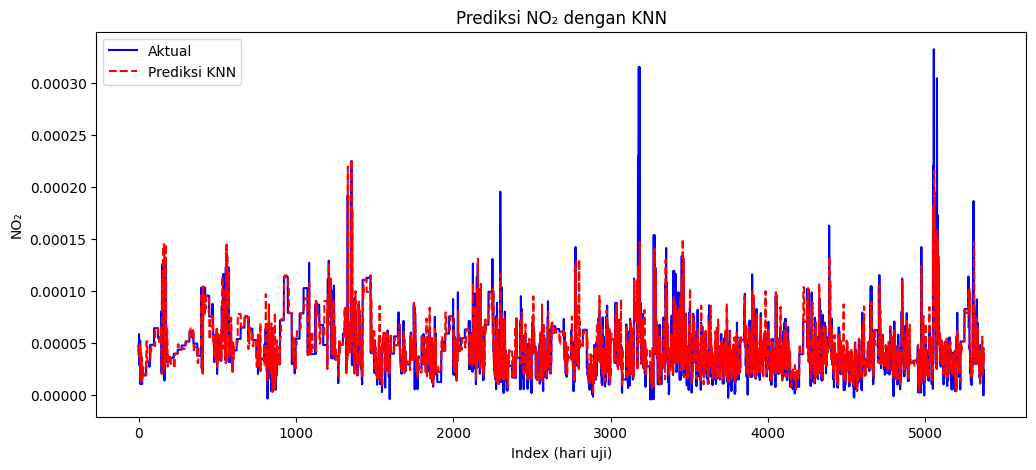

In [81]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Aktual", color="blue")
plt.plot(y_pred, label="Prediksi KNN", color="red", linestyle="--")
plt.title("Prediksi NO₂ dengan KNN")
plt.xlabel("Index (hari uji)")
plt.ylabel("NO₂")
plt.legend()
plt.show()

## **6. Eksperimen dengan beberapa Lag feature** 

| Lag | Tujuan utama | Catatan singkat |
|---|---|---|
| 1, 2, 3 | **Pola jangka pendek** | Respons cepat dari hari ke hari |
| 7 | **Siklus mingguan** | Efek pola aktivitas mingguan |
| 14 | **Dua mingguan** | Memperkuat pola mingguan |
| 30 | **Bulanan** | Menangkap tren bulanannya |

In [83]:
import itertools

lags = [1, 2, 3, 7, 14, 30]
for lag in lags:
    df[f'NO2_lag{lag}'] = df['NO2'].shift(lag)

# drop NaN
df_exp = df.dropna().reset_index(drop=True)

# Definisikan kombinasi fitur yang mau diuji
feature_sets = [
    ['NO2_lag1', 'NO2_lag7'],
    ['NO2_lag1', 'NO2_lag7', 'NO2_lag14'],
    ['NO2_lag1', 'NO2_lag7', 'NO2_lag14', 'NO2_lag30'],
    ['NO2_lag1', 'NO2_lag2', 'NO2_lag3', 'NO2_lag7', 'NO2_lag14'],
]

# Loop eksperimen
results = []
for feats in feature_sets:
    X = df_exp[feats].values
    y = df_exp['NO2'].values

    # scaling
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # split train/test (80/20)
    split = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:split], X_scaled[split:]
    y_train, y_test = y[:split], y[split:]

    # KNN model
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # evaluasi
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append((feats, mae, rmse))

# Tampilkan hasil
for feats, mae, rmse in results:
    print(f"Fitur {feats} -> MAE: {mae:.6f}, RMSE: {rmse:.6f}")

Fitur ['NO2_lag1', 'NO2_lag7'] -> MAE: 0.000012, RMSE: 0.000021
Fitur ['NO2_lag1', 'NO2_lag7', 'NO2_lag14'] -> MAE: 0.000011, RMSE: 0.000020
Fitur ['NO2_lag1', 'NO2_lag7', 'NO2_lag14', 'NO2_lag30'] -> MAE: 0.000011, RMSE: 0.000020
Fitur ['NO2_lag1', 'NO2_lag2', 'NO2_lag3', 'NO2_lag7', 'NO2_lag14'] -> MAE: 0.000011, RMSE: 0.000020


## **7. Kesimpulan**

Secara keseluruhan, analisis kita menunjukkan bahwa pendekatan KNN untuk memodelkan konsentrasi NO₂ harian sudah berjalan baik dengan pipeline yang rapi: data dibersihkan, dibentuk menjadi supervised melalui lag features, dinormalisasi dengan MinMaxScaler, lalu dipisahkan train/test sebelum dilatih dengan KNN. Evaluasi menggunakan MAE dan RMSE menghasilkan error yang sangat kecil, menandakan model mampu meniru pola data dengan baik. Dari eksperimen fitur, kombinasi lag1 dan lag7 sudah cukup kuat untuk menangkap pola harian dan mingguan, sementara penambahan lag14 memberi sedikit perbaikan, tetapi lag30 maupun tambahan lag pendek (lag2, lag3) tidak memberikan peningkatan berarti. Dengan demikian, kombinasi lag1, lag7, dan lag14 bisa dianggap sebagai titik yang seimbang antara akurasi dan kompleksitas.